In [80]:
import config
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine


In [81]:
#import config dataW
mysql = config.mysql

#connect to database
connection_string = (
    f"postgresql://{mysql['user']}:{mysql['password']}@"
    f"{mysql['host']}:{mysql['port']}/{mysql['dbname']}"
)

engine = create_engine(connection_string)

# To create a connection, you can use
conn = engine.connect()
    

In [82]:
#list of provinces in  Poland
provinces = [
    "dolnoslaskie"
    ,"kujawsko_pomorskie"
    ,"lubelskie"
    ,"lubuskie"
    ,"lodzkie"
    ,"malopolskie"
    ,"mazowieckie"
    ,"opolskie"
    ,"podkarpackie"
    ,"podlaskie"
    ,"pomorskie"
    ,"slaskie"
    ,"swietokrzyskie"
    ,"warminsko_mazurskie"
    ,"wielkopolskie"
    ,"zachodniopomorskie"
    ]

In [83]:
#dataframe to province total area renewable solar and wind
solar_area_append_total = {'Province': [], 'solar_area': []}
wind_area_append_total = {'Province': [], 'wind_area': []}

# Import data from database
for province in provinces:
    #select tables
    table_name_solar = f"solar_radiation_photovoltaic_area_{province}"
    table_name_wind = f"wind_speed_area_{province}"
    
    #select data in tables
    query_solar = (f"SELECT SUM(area) as solar_total_area "
                   f"FROM {table_name_solar}")
    query_wind = (f"SELECT SUM(area) as wind_total_area "
                  f"FROM {table_name_wind}")
    #result to pandas
    solar_result = pd.read_sql(query_solar, conn)
    wind_result = pd.read_sql(query_wind, conn)
    
    #check select data 
    if not solar_result.empty and solar_result['solar_total_area'][0] is not None:
        solar_area = solar_result['solar_total_area'][0]
    else:
        solar_area = 0

    if not wind_result.empty and wind_result['wind_total_area'][0] is not None:
        wind_area = wind_result['wind_total_area'][0]
    else:
        wind_area = 0
    
    #append data to column and change m^2 to km^2
    solar_area_append_total['Province'].append(province)
    solar_area_append_total['solar_area'].append(round(solar_area * 1e-6,2))
    
    
    wind_area_append_total['Province'].append(province)
    wind_area_append_total['wind_area'].append(round(wind_area * 1e-6,2))

    

df_solar = pd.DataFrame(solar_area_append_total)
df_wind = pd.DataFrame(wind_area_append_total)
df_solar


,Province,solar_area
0,dolnoslaskie,480.64
1,kujawsko_pomorskie,262.50
2,lubelskie,594.29
3,lubuskie,326.41
4,lodzkie,485.20
5,malopolskie,441.87
6,mazowieckie,1344.64
7,opolskie,90.20
8,podkarpackie,568.48
9,podlaskie,962.12


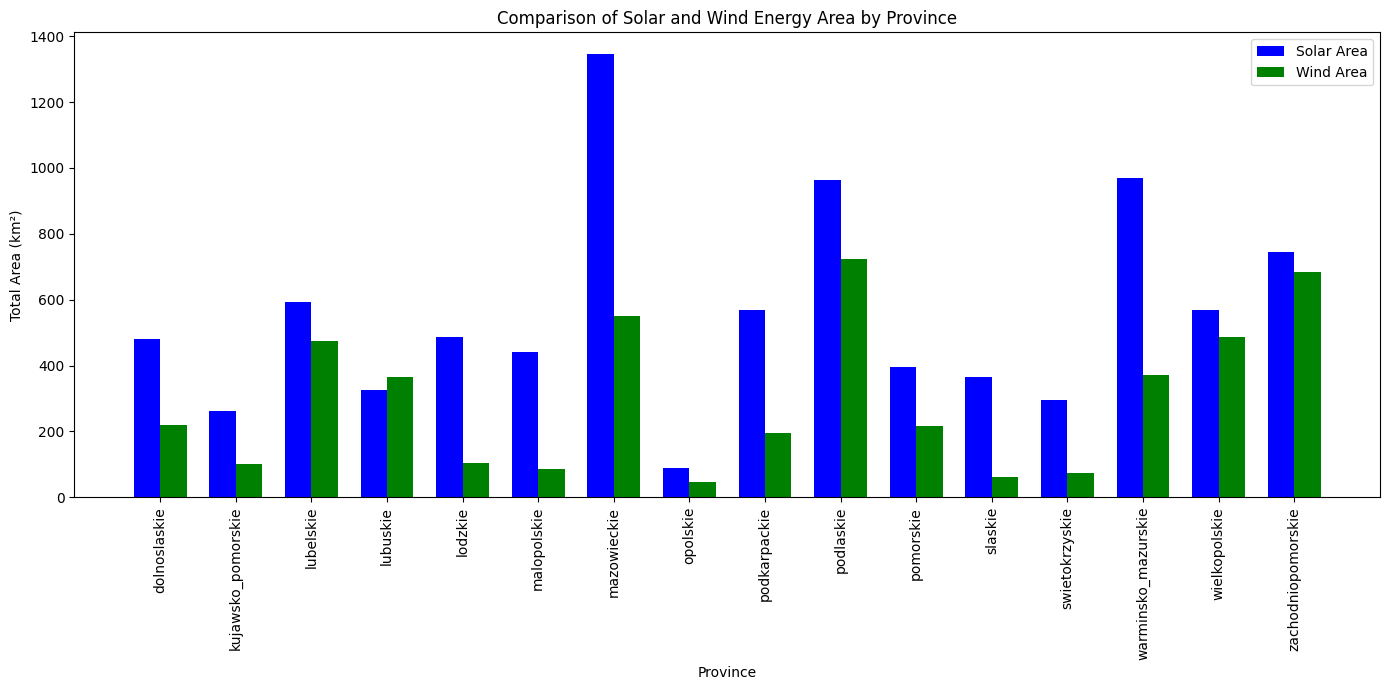

In [84]:
# Generowanie wykresu słupkowego
plt.figure(figsize=(14, 7))
width = 0.35  # szerokość słupków

# Pozycje słupków dla każdego województwa
ind = range(len(df_solar['Province']))

# Tworzenie słupków dla energii słonecznej i wiatrowej
plt.bar(ind, df_solar['solar_area'], width=width, label='Solar Area', color='blue')
plt.bar([i + width for i in ind], df_wind['wind_area'], width=width, label='Wind Area', color='green')

# Dodanie opisów i tytułu
plt.xlabel('Province')
plt.ylabel('Total Area (km²)')
plt.title('Comparison of Solar and Wind Energy Area by Province')
plt.xticks([i + width / 2 for i in ind], df_solar['Province'], rotation=90)
plt.legend()

# Wyświetlenie wykresu
plt.tight_layout()
plt.show()

In [85]:
#photovoltaic standard panels parametrs [km^2]
height_panel = 1.016
width_panel = 1.686
power_output = 350 #[W]
power_output_m2 = power_output / (height_panel * width_panel)

#panel efficiency by producent 25*C, 1000 [Wm^2]/ power efficency ~20%
efficiency = (power_output / (height_panel*width_panel  * 1000))
efficiency

#power_per_m2 = efficiency_producent_m2 * irradiance


0.2043227692623831

In [86]:
#create effective area. We can't use whole area. In this case we use 80% area to solar panels and 20% for equipment and maintenance access
#parametrs 
solar_maintenance_access = 0.2
effective_solar_panel_area = 1 - solar_maintenance_access

#calculate the effective area
df_solar['solar_effective_area'] = (df_solar['solar_area'] * effective_solar_panel_area)
df_solar

,Province,solar_area,solar_effective_area
0,dolnoslaskie,480.64,384.512
1,kujawsko_pomorskie,262.50,210.000
2,lubelskie,594.29,475.432
3,lubuskie,326.41,261.128
4,lodzkie,485.20,388.160
5,malopolskie,441.87,353.496
6,mazowieckie,1344.64,1075.712
7,opolskie,90.20,72.160
8,podkarpackie,568.48,454.784
9,podlaskie,962.12,769.696


In [87]:
#select tables
months = {
    "january" : 31
    , "february" : 28
    , "march" : 31
    , "april" : 30
    ,"may" : 31
    , "june" : 30
    , "july" : 31
    , "august" : 31
    ,"september" : 30
    , "october" : 31
    , "november" : 30
    , "december" : 31
}

#solar radiation by province and each month
solar_radiation = pd.DataFrame(index=provinces, columns=months.keys())

for province in provinces:
    for month in months:
        table_name_solar = f"solar_radiation_photovoltaic_area_{province}"
        # select data in tables
        #sum of multipe area in m^2 * amount of solar radiation in month [kW] * effective area (80%) * efficency of solar panel and change to GW
        query = f"SELECT SUM(area * {month} * {effective_solar_panel_area} * {efficiency} * 1e-6) as total FROM {table_name_solar}"

        # result to pandas
        result_df = pd.read_sql(query, conn)
        monthly_solar_energy = result_df.iloc[0]['total'] if not result_df.empty else 0
        solar_radiation.at[province, month] = monthly_solar_energy
        
#rename index        
solar_radiation.reset_index(inplace=True)
solar_radiation.rename(columns={'index': 'Province'}, inplace=True)

#merge df_solar and solar_radiation
df_solar = df_solar.merge(solar_radiation, left_on='Province', right_on='Province')
df_solar

,Province,solar_area,solar_effective_area,january,february,march,april,may,june,july,august,september,october,november,december
0,dolnoslaskie,480.64,384.512,3005.597594,5726.130953,9969.59251,14436.185442,17494.379106,19288.067877,18579.257957,15567.067409,11067.988996,6653.764779,3498.790849,2289.338812
1,kujawsko_pomorskie,262.50,210.000,1253.316566,2638.660624,5028.382712,7717.159774,9748.206724,10689.751515,10061.34998,8267.318665,5700.930373,3219.258181,1498.563364,902.843694
2,lubelskie,594.29,475.432,3462.206789,6788.518199,12121.101665,17915.957141,22176.692383,24288.575446,23505.793502,19633.60987,13731.005148,8069.533741,4010.026759,2573.77072
3,lubuskie,326.41,261.128,1676.477581,3388.947979,6309.736242,9583.646546,11983.212771,13193.690023,12462.035708,10312.29051,7224.36148,4169.014683,2047.522738,1247.462286
4,lodzkie,485.20,388.160,2737.488158,5408.555601,9739.979669,14522.229222,17958.518403,19711.598194,18881.779547,15711.574745,11030.232087,6474.390233,3230.708261,2046.007824
5,malopolskie,441.87,353.496,3163.483883,5756.065324,9614.633313,13457.598644,15981.381008,17568.8918,17300.125555,14645.387443,10497.561836,6504.8076,3606.504996,2470.887907
6,mazowieckie,1344.64,1075.712,6825.379808,14085.361806,26299.218287,39830.069646,50035.850118,54735.535399,52212.212618,43088.882247,29808.814816,17009.679999,8075.151895,4948.137125
7,opolskie,90.20,72.160,565.810777,1070.627875,1857.98248,2715.001863,3312.812643,3654.696664,3527.142607,2956.837962,2101.976349,1262.61791,659.715124,434.136705
8,podkarpackie,568.48,454.784,3771.322721,7015.155159,12009.967926,17193.345249,20863.441956,22941.906608,22580.780973,19104.065169,13535.592251,8198.95763,4373.56474,2915.744347
9,podlaskie,962.12,769.696,4479.572668,9610.715473,18429.102541,28106.905339,35629.455007,38816.48571,36884.551242,30219.017153,20611.208924,11488.96637,5246.601955,3146.551566


In [88]:
#wind production

In [87]:
for province in provinces:
    for month in months:
        table_name_solar = f"solar_radiation_photovoltaic_area_{province}"
        # select data in tables
        #sum of multipe area in m^2 * amount of solar radiation in month [kW] * effective area (80%) * efficency of solar panel and change to GW
        query = f"SELECT SUM(area * {month} * {effective_solar_panel_area} * {efficiency} * 1e-6) as total FROM {table_name_solar}"

        # result to pandas
        result_df = pd.read_sql(query, conn)
        monthly_solar_energy = result_df.iloc[0]['total'] if not result_df.empty else 0
        solar_radiation.at[province, month] = monthly_solar_energy
        
#rename index        
solar_radiation.reset_index(inplace=True)
solar_radiation.rename(columns={'index': 'Province'}, inplace=True)

#merge df_solar and solar_radiation
df_solar = df_solar.merge(solar_radiation, left_on='Province', right_on='Province')
df_solar